In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# src files
from situation_testing.situation_testing import SituationTesting
# plot params
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [2]:
# working directory
wd = os.path.dirname(os.getcwd())
# relevant folders
data_path = os.path.abspath(os.path.join(wd, 'data')) + '\\'
resu_path = os.path.abspath(os.path.join(wd, 'results')) + '\\'

In [3]:
# factual dataset
org_df    = pd.read_csv(data_path + 'LoanApplication_v2.csv', sep='|', )
# counterfactual dataset
org_cf_df = pd.read_csv(data_path + 'counterfactuals\\cf_LoanApplication_v2.csv', sep='|', )

## The impact of $|k|$, given $\tau$

In [4]:
### data
test_df    = org_df.copy()
test_cf_df = org_cf_df.copy()

### parameters
alpha = 0.05
tau   = 0.0
k_l = 1
# k_u = 250
k_u = 500

### ST object
st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

### CST object
cst = SituationTesting()
cst.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

In [5]:
temp_k = []

for k in range(k_l, k_u + 1):
    print(k)
    
    # --- ST
    st.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
           sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1}, 
           k=k, alpha=alpha, tau=tau)
    
    temp_test_disc_st = st.get_test_discrimination()
    
    # --- CST without
    cst.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1}, 
            sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
            include_centers=False, 
            k=k, alpha=alpha, tau=tau)
    
    temp_test_disc_wo = cst.get_test_discrimination()
    
    # --- CST with
    cst.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1}, 
            sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
            include_centers=True, 
            k=k, alpha=alpha, tau=tau)
    
    temp_test_disc_wi = cst.get_test_discrimination()
    
    # --- CF
    cf = cst.res_counterfactual_unfairness
    
    # --- results
    temp_k.append(
        {
        'k': k,
        # Num. of discrimination cases
        'ST_num': temp_test_disc_st[temp_test_disc_st['DiscEvi'] == 'Yes'].shape[0],
        'CSTwo_num': temp_test_disc_wo[temp_test_disc_wo['DiscEvi'] == 'Yes'].shape[0],
        'CSTwi_num': temp_test_disc_wi[temp_test_disc_wi['DiscEvi'] == 'Yes'].shape[0],
        'ST_num_sig': temp_test_disc_st[(temp_test_disc_st['DiscEvi'] == 'Yes') & (temp_test_disc_st['StatEvi'] == 'Yes')].shape[0],
        'CSTwo_num_sig': temp_test_disc_wo[(temp_test_disc_wo['DiscEvi'] == 'Yes') & (temp_test_disc_wo['StatEvi'] == 'Yes')].shape[0],
        'CSTwi_num_sig': temp_test_disc_wi[(temp_test_disc_wi['DiscEvi'] == 'Yes') & (temp_test_disc_wi['StatEvi'] == 'Yes')].shape[0],
        'CF_num': sum(cf == 1),
        'CF_num_sig': temp_test_disc_wi[temp_test_disc_wi['individual'].isin(cf[cf == 1].index.to_list()) & (temp_test_disc_wi['StatEvi'] == 'Yes')].shape[0],
        'CF_avgCI_l': temp_test_disc_wi['CI_2st'].apply(lambda x: x[0]).mean(),
        'CF_avgCI_u': temp_test_disc_wi['CI_2st'].apply(lambda x: x[-1]).mean(),
        # Avg. delta p
        'ST_diff': temp_test_disc_st[temp_test_disc_st['DiscEvi'] == 'Yes']['delta_p'].mean(),
        'CSTwo_diff': temp_test_disc_wo[temp_test_disc_wo['DiscEvi'] == 'Yes']['delta_p'].mean(),
        'CSTwi_diff': temp_test_disc_wi[temp_test_disc_wi['DiscEvi'] == 'Yes']['delta_p'].mean(),
        'ST_diff_sig': temp_test_disc_st[(temp_test_disc_st['DiscEvi'] == 'Yes') & (temp_test_disc_st['StatEvi'] == 'Yes')]['delta_p'].mean(),
        'CSTwo_diff_sig': temp_test_disc_wo[(temp_test_disc_wo['DiscEvi'] == 'Yes') & (temp_test_disc_wo['StatEvi'] == 'Yes')]['delta_p'].mean(),
        'CSTwi_diff_sig': temp_test_disc_wi[(temp_test_disc_wi['DiscEvi'] == 'Yes') & (temp_test_disc_wi['StatEvi'] == 'Yes')]['delta_p'].mean(),
        }
    )
    
    del temp_test_disc_wo, temp_test_disc_wi, temp_test_disc_st, cf
print('=== DONE ===')

k_results = pd.DataFrame(temp_k)
del temp_k

k_results.to_csv(resu_path + '\\res_LoanApplication_k_analysis.csv', sep='|', index=True)
k_results.head(5)
print('=== SAVED ===')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


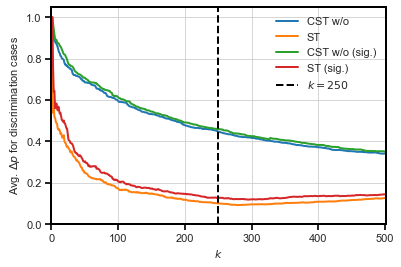

In [14]:
plt.plot(k_results['k'], k_results['CSTwo_diff'], label='CST w/o')
plt.plot(k_results['k'], k_results['ST_diff'], label='ST')
plt.plot(k_results['k'], k_results['CSTwo_diff_sig'], label='CST w/o (sig.)')
plt.plot(k_results['k'], k_results['ST_diff_sig'], label='ST (sig.)')
plt.xlim(0, k_u+1)
plt.xlabel("$k$")
plt.ylim(0.0, 1.05)
plt.ylabel("Avg. $\Delta p$ for discrimination cases")
plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
plt.legend()
# plt.title('CST w/o vs ST')
plt.show()

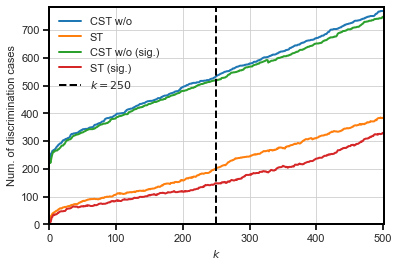

In [15]:
plt.plot(k_results['k'], k_results['CSTwo_num'], label='CST w/o')
plt.plot(k_results['k'], k_results['ST_num'], label='ST')
plt.plot(k_results['k'], k_results['CSTwo_num_sig'], label='CST w/o (sig.)')
plt.plot(k_results['k'], k_results['ST_num_sig'], label='ST (sig.)')
plt.xlim(0, k_u+1)
plt.xlabel("$k$")
plt.ylim(0, k_results.iloc[-1].max() + 15)
# plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
plt.ylabel("Num. of discrimination cases")
plt.legend()
# plt.title('CST w/o vs ST')
plt.show()

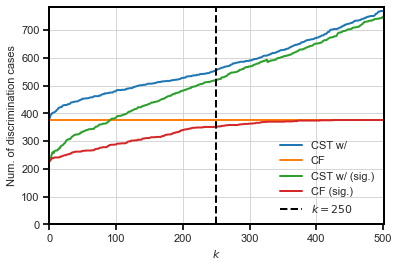

In [16]:
plt.plot(k_results['k'], k_results['CSTwi_num'], label='CST w/')
plt.plot(k_results['k'], k_results['CF_num'], label='CF')
plt.plot(k_results['k'], k_results['CSTwi_num_sig'], label='CST w/ (sig.)')
plt.plot(k_results['k'], k_results['CF_num_sig'], label='CF (sig.)')
plt.xlim(0, k_u+1)
plt.xlabel("$k$")
plt.ylim(0, k_results.iloc[-1].max() + 15)
# plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
plt.ylabel("Num. of discrimination cases")
plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
plt.legend()
# plt.title('CST w/ vs CF')
plt.show()

In [17]:
# plt.plot(k_results['k'], k_results['CF_avgCI_l'], label='avg. lower CI', linestyle='--')
# plt.plot(k_results['k'], k_results['CF_avgCI_u'], label='avg. upper CI', linestyle='--')
# # plt.plot(k_results['k'], k_results['CF_d1_num'], label='CF')
# # plt.plot(k_results['k'], k_results['CF_d2_num'], label='CF (sig.)')
# plt.axhline(y=0.0, label='$\\tau$', color='g')
# plt.xlim(0, k_u+1)
# plt.xlabel("$k$")
# plt.ylim(-1, 1)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.ylabel("Uncertainty around CF")
# plt.legend()
# plt.title('CST w/ vs CF')
# plt.show()

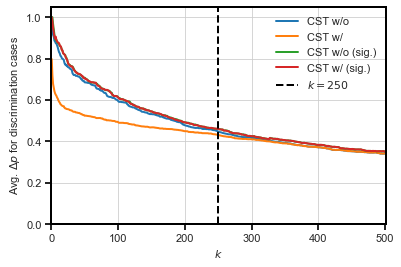

In [21]:
plt.plot(k_results['k'], k_results['CSTwo_diff'], label='CST w/o')
plt.plot(k_results['k'], k_results['CSTwi_diff'], label='CST w/')
plt.plot(k_results['k'], k_results['CSTwo_diff_sig'], label='CST w/o (sig.)')
plt.plot(k_results['k'], k_results['CSTwi_diff_sig'], label='CST w/ (sig.)')
plt.xlim(0, k_u+1)
plt.xlabel("$k$")
plt.ylim(0.0, 1.05)
plt.ylabel("Avg. $\Delta p$ for discrimination cases")
plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
plt.legend()
# plt.title('CST w/o vs CST w/')
plt.show()

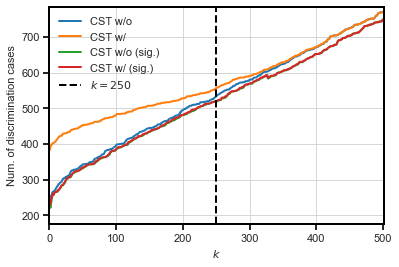

In [20]:
plt.plot(k_results['k'], k_results['CSTwo_num'], label='CST w/o')
plt.plot(k_results['k'], k_results['CSTwi_num'], label='CST w/')
plt.plot(k_results['k'], k_results['CSTwo_num_sig'], label='CST w/o (sig.)')
plt.plot(k_results['k'], k_results['CSTwi_num_sig'], label='CST w/ (sig.)')
plt.xlim(0, k_u+1)
plt.xlabel("$k$")
plt.ylim(175, k_results.iloc[-1].max() + 15)
# plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
plt.ylabel("Num. of discrimination cases")
plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
plt.legend()
# plt.title('CST w/o vs CST w/')
plt.show()

## The impact of $|\tau|$, given $K$

In [ ]:
### data
test_df    = org_df.copy()
test_cf_df = org_cf_df.copy()

### parameters
alpha = 0.05
tau   = 0.0
n = 15

### CST object
cst = SituationTesting()
cst.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

In [ ]:
# d1: discrimination definition based on the literal comparison
# d2: discrimination definition based on statistical significance

temp_tau = []

for tau in np.arange(0.0, 1.05, 0.05): 
    print(round(tau, 2))
    
    # --- CST without
    cst.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1}, 
            sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
            include_centers=False, 
            k=n, alpha=alpha, tau=round(tau, 2))
    
    temp_test_disc_wo = cst.get_test_discrimination()
    
    # --- CST with
    cst.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1}, 
            sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
            include_centers=True, 
            k=n, alpha=alpha, tau=round(tau, 2))
    
    temp_test_disc_wi = cst.get_test_discrimination()
    
    # --- results
    temp_tau.append(
        {
        'tau': round(tau, 2),
        # Num. of discrimination cases
        'CST_wo_d1_num': temp_test_disc_wo[temp_test_disc_wo['DiscEvi'] == 'Yes'].shape[0],
        'CST_wi_d1_num': temp_test_disc_wi[temp_test_disc_wi['DiscEvi'] == 'Yes'].shape[0],
        'CST_wo_d2_num': temp_test_disc_wo[(temp_test_disc_wo['DiscEvi'] == 'Yes') & (temp_test_disc_wo['StatEvi'] == 'Yes')].shape[0],
        'CST_wi_d2_num': temp_test_disc_wi[(temp_test_disc_wi['DiscEvi'] == 'Yes') & (temp_test_disc_wi['StatEvi'] == 'Yes')].shape[0],
        # Avg. delta p
        'CST_wo_d1_diff': temp_test_disc_wo[temp_test_disc_wo['DiscEvi'] == 'Yes']['org_diff'].mean(),
        'CST_wi_d1_diff': temp_test_disc_wi[temp_test_disc_wi['DiscEvi'] == 'Yes']['org_diff'].mean(),
        'CST_wo_d2_diff': temp_test_disc_wo[(temp_test_disc_wo['DiscEvi'] == 'Yes') & (temp_test_disc_wo['StatEvi'] == 'Yes')]['org_diff'].mean(),
        'CST_wi_d2_diff': temp_test_disc_wi[(temp_test_disc_wi['DiscEvi'] == 'Yes') & (temp_test_disc_wi['StatEvi'] == 'Yes')]['org_diff'].mean(),
        }
    )
    
    del temp_test_disc_wo, temp_test_disc_wi

tau_results = pd.DataFrame(temp_tau)
del temp_tau

print('=== DONE ===')

In [ ]:
plt.plot(tau_results['tau'], tau_results['CST_wo_d1_diff'], label='CST w/o (D1)')
plt.plot(tau_results['tau'], tau_results['CST_wi_d1_diff'], label='CST (D1)')
plt.plot(tau_results['tau'], tau_results['CST_wo_d2_diff'], label='CST w/o (D2)')
plt.plot(tau_results['tau'], tau_results['CST_wi_d2_diff'], label='CST (D2)')
plt.xlim(-0.05, 1.05)
plt.xlabel(f"$\\tau$ (with $k$={n})")
plt.ylim(0.0, 1.05)
plt.ylabel("Avg. $\Delta p$ for discrimination cases")
plt.legend()
# plt.title('multiple plots')
plt.show()

In [ ]:
plt.plot(tau_results['tau'], tau_results['CST_wo_d1_num'], label='CST w/o (D1)')
plt.plot(tau_results['tau'], tau_results['CST_wi_d1_num'], label='CST (D1)')
plt.plot(tau_results['tau'], tau_results['CST_wo_d2_num'], label='CST w/o (D2)')
plt.plot(tau_results['tau'], tau_results['CST_wi_d2_num'], label='CST (D1)')
plt.xlim(-0.05, 1.05)
plt.xlabel(f"$\\tau$ (with $k$={n})")
# plt.ylim(200, tau_results.iloc[-1].max() + 15)
plt.ylabel("Num. of discrimination cases")
plt.legend()
# plt.title('multiple plots')
plt.show()

In [ ]:
# The tau results further reinforce the results: notce the drop in CST w/ under Def 1!!!

In [ ]:
### data
test_df    = org_df.copy()
test_cf_df = org_cf_df.copy()

### parameters
alpha = 0.05
tau   = 0.0
n = 250

### CST object
cst = SituationTesting()
cst.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

In [ ]:
# d1: discrimination definition based on the literal comparison
# d2: discrimination definition based on statistical significance

temp_tau = []

for tau in np.arange(0.0, 1.05, 0.05): 
    print(round(tau, 2))
    
    # --- CST without
    cst.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1}, 
            sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
            include_centers=False, 
            k=n, alpha=alpha, tau=round(tau, 2))
    
    temp_test_disc_wo = cst.get_test_discrimination()
    
    # --- CST with
    cst.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1}, 
            sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
            include_centers=True, 
            k=n, alpha=alpha, tau=round(tau, 2))
    
    temp_test_disc_wi = cst.get_test_discrimination()
    
    # --- results
    temp_tau.append(
        {
        'tau': round(tau, 2),
        # Num. of discrimination cases
        'CST_wo_d1_num': temp_test_disc_wo[temp_test_disc_wo['DiscEvi'] == 'Yes'].shape[0],
        'CST_wi_d1_num': temp_test_disc_wi[temp_test_disc_wi['DiscEvi'] == 'Yes'].shape[0],
        'CST_wo_d2_num': temp_test_disc_wo[(temp_test_disc_wo['DiscEvi'] == 'Yes') & (temp_test_disc_wo['StatEvi'] == 'Yes')].shape[0],
        'CST_wi_d2_num': temp_test_disc_wi[(temp_test_disc_wi['DiscEvi'] == 'Yes') & (temp_test_disc_wi['StatEvi'] == 'Yes')].shape[0],
        # Avg. delta p
        'CST_wo_d1_diff': temp_test_disc_wo[temp_test_disc_wo['DiscEvi'] == 'Yes']['org_diff'].mean(),
        'CST_wi_d1_diff': temp_test_disc_wi[temp_test_disc_wi['DiscEvi'] == 'Yes']['org_diff'].mean(),
        'CST_wo_d2_diff': temp_test_disc_wo[(temp_test_disc_wo['DiscEvi'] == 'Yes') & (temp_test_disc_wo['StatEvi'] == 'Yes')]['org_diff'].mean(),
        'CST_wi_d2_diff': temp_test_disc_wi[(temp_test_disc_wi['DiscEvi'] == 'Yes') & (temp_test_disc_wi['StatEvi'] == 'Yes')]['org_diff'].mean(),
        }
    )
    
    del temp_test_disc_wo, temp_test_disc_wi

tau_results = pd.DataFrame(temp_tau)
del temp_tau

print('=== DONE ===')

In [ ]:
plt.plot(tau_results['tau'], tau_results['CST_wo_d1_diff'], label='CST w/o (D1)')
plt.plot(tau_results['tau'], tau_results['CST_wi_d1_diff'], label='CST (D1)')
plt.plot(tau_results['tau'], tau_results['CST_wo_d2_diff'], label='CST w/o (D2)')
plt.plot(tau_results['tau'], tau_results['CST_wi_d2_diff'], label='CST (D2)')
plt.xlim(-0.05, 1.05)
plt.xlabel(f"$\\tau$ (with $k$={n})")
plt.ylim(0.0, 1.05)
plt.ylabel("Avg. $\Delta p$ for discrimination cases")
plt.legend()
# plt.title('multiple plots')
plt.show()

In [ ]:
plt.plot(tau_results['tau'], tau_results['CST_wo_d1_num'], label='CST w/o (D1)')
plt.plot(tau_results['tau'], tau_results['CST_wi_d1_num'], label='CST (D1)')
plt.plot(tau_results['tau'], tau_results['CST_wo_d2_num'], label='CST w/o (D2)')
plt.plot(tau_results['tau'], tau_results['CST_wi_d2_num'], label='CST (D1)')
plt.xlim(-0.05, 1.05)
plt.xlabel(f"$\\tau$ (with $k$={n})")
# plt.ylim(200, tau_results.iloc[-1].max() + 15)
plt.ylabel("Num. of discrimination cases")
plt.legend()
# plt.title('multiple plots')
plt.show()

### EOF